In [5]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.5.1
CUDA available: True


In [10]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.5.1
CUDA available: True


  Using cached xgboost-3.2.0-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.3 MB 5.6 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/11.3 MB 3.4 MB/s eta 0:00:03
   ------- -------------------------------- 2.1/11.3 MB 3.4 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/11.3 MB 3.5 MB/s eta 0:00:03
   ------------ --------------------------- 3.7/11.3 MB 3.5 MB/s eta 0:00:03
   --------------- ------------------------ 4.5/11.3 MB 3.6 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.3 MB 3.7 MB/s eta

In [11]:
import xgboost as xgb
print(xgb.__version__)

3.2.0


In [14]:
# ============================================================
# CELL 1 (方案B): Thesis slicing split（每个主变量取值=一个 slice）
# 注意：要真正做 thesis，多模型训练，Cell2 的循环也要改
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("clean_ul_with_conditions2.csv")

target_col = "pm_power"

# thesis 切片：这里的 FEATURE_SETS 不是“特征集合”，而是“用哪个变量切片”
EXPERIMENTS = {
    "gain": "txgain",
    "mcs": "selected_mcs",
    "airtime": "airtime",
}

# 每个 slice 内模型输入通常用 conditions（主变量已固定，不一定放进输入）
COND_FEATURES = ["traffic_load", "BW", "nRBs", "clockspeed"]

def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()
    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()
    return d

def split_within_slice(d_slice, seed=42, train_ratio=0.8, val_ratio_within_train=0.1):
    train_df, test_df = train_test_split(d_slice, test_size=(1-train_ratio), random_state=seed)
    train_df, val_df  = train_test_split(train_df, test_size=val_ratio_within_train, random_state=seed)
    return train_df, val_df, test_df


In [16]:
# ============================================================
# CELL 2 (方案B / Thesis slicing) — Model1 BaselineDNN
# 每个主变量取值 (slice) 单独训练一个模型
# 输入特征：COND_FEATURES（主变量已固定，通常不放进输入）
# ============================================================

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ------------------------------------------------------------
# 1) Dataset wrapper for PyTorch
# ------------------------------------------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ------------------------------------------------------------
# 2) Baseline DNN (Model 1)
# ------------------------------------------------------------
class BaselineDNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# ------------------------------------------------------------
# 3) Mean Relative Error (percentage)
# ------------------------------------------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)


# ------------------------------------------------------------
# 4) Train & Eval one slice
# ------------------------------------------------------------
def train_eval_model1_slice(
    train_df,
    val_df,
    test_df,
    feature_cols,
    target_col,
    epochs=200,
    batch_size=64,
    lr=1e-3,
    seed=42,
    verbose_every=10
):
    # Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Extract arrays
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values.astype(float)

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values.astype(float)

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values.astype(float)

    # Standardization (fit only on training)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    train_loader = DataLoader(TabularDataset(X_train_s, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TabularDataset(X_val_s,   y_val),   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TabularDataset(X_test_s,  y_test),  batch_size=batch_size, shuffle=False)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BaselineDNN(in_dim=len(feature_cols)).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val_loss = float("inf")
    best_state = None

    # Training loop
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(xb)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item() * len(xb)
        val_loss /= len(val_loader.dataset)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | Train MSE {train_loss:.6f} | Val MSE {val_loss:.6f}")

    model.load_state_dict(best_state)

    # Test eval
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy().reshape(-1)
            y_pred_list.append(pred)
            y_true_list.append(yb.numpy().reshape(-1))

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": float(mse),
        "rmse": float(rmse),
        "mae": float(mae),
        "mre_pct": float(mre),
        "y_true": y_true,
        "y_pred": y_pred,
        "model": model,
        "scaler": scaler,
    }


# ------------------------------------------------------------
# 5) Thesis slicing experiment loop
# ------------------------------------------------------------
results = []
trained_models_m1_slices = {}     # trained_models_m1_slices[exp_name][slice_value] = {model, scaler}
test_outputs_m1_slices = {}       # optional: store predictions per slice

MIN_SLICE_SIZE = 30  # 太小的 slice 就跳过（你可以调大/调小）

for exp_name, slice_col in EXPERIMENTS.items():
    print("\n" + "="*70)
    print(f"[Thesis] Experiment: {exp_name} | slice_col = {slice_col}")
    print("="*70)

    # 这一轮需要的列：slice_col + cond features + target
    cols_needed = [slice_col] + COND_FEATURES + [target_col]
    d = clean_numeric_df(df, cols_needed, target_col)

    # 强制把 slice_col 转成数值（避免字符串导致 group 乱）
    d[slice_col] = pd.to_numeric(d[slice_col], errors="coerce")
    d = d.dropna(subset=[slice_col]).copy()

    trained_models_m1_slices.setdefault(exp_name, {})
    test_outputs_m1_slices.setdefault(exp_name, {})

    # 对每个 slice value 单独训练
    for sval, d_slice in d.groupby(slice_col):
        d_slice = d_slice.copy()

        if len(d_slice) < MIN_SLICE_SIZE:
            # 样本太少，不适合拆 train/val/test
            continue

        # slice 内随机拆分
        train_df, val_df, test_df = split_within_slice(
            d_slice, seed=42, train_ratio=0.8, val_ratio_within_train=0.1
        )

        # 再做一个安全检查：避免 val/test 太小
        if len(train_df) < 10 or len(val_df) < 5 or len(test_df) < 5:
            continue

        print(f"\n--- slice {slice_col} = {sval} | sizes: "
              f"train={len(train_df)}, val={len(val_df)}, test={len(test_df)} ---")

        out = train_eval_model1_slice(
            train_df, val_df, test_df,
            feature_cols=COND_FEATURES,   # thesis slicing: 用条件特征作为输入
            target_col=target_col,
            epochs=100,
            batch_size=64,
            lr=1e-3,
            seed=42,
            verbose_every=20
        )

        results.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": float(sval),
            "model": "Model1 (BaselineDNN, slice-wise)",
            "features": ",".join(COND_FEATURES),
            "MSE": out["mse"],
            "RMSE": out["rmse"],
            "MAE": out["mae"],
            "MRE(%)": out["mre_pct"],
            "n_train": len(train_df),
            "n_val": len(val_df),
            "n_test": len(test_df),
        })

        trained_models_m1_slices[exp_name][float(sval)] = {
            "model": out["model"],
            "scaler": out["scaler"]
        }

        test_outputs_m1_slices[exp_name][float(sval)] = {
            "test_df": test_df.copy(),
            "y_true": out["y_true"],
            "y_pred_m1": out["y_pred"],
        }

results_df = pd.DataFrame(results)

print("\n=== Thesis Slicing Results (Model1) ===")
display(results_df)

print("\n=== Sorted by MRE(%) ===")
print(results_df.sort_values(["experiment", "MRE(%)"]))



[Thesis] Experiment: gain | slice_col = txgain

--- slice txgain = 20 | sizes: train=36, val=5, test=11 ---
Epoch 001 | Train MSE 119.573326 | Val MSE 120.809792
Epoch 020 | Train MSE 106.671303 | Val MSE 107.604080
Epoch 040 | Train MSE 63.631477 | Val MSE 62.909271
Epoch 060 | Train MSE 13.093489 | Val MSE 11.803134
Epoch 080 | Train MSE 5.964615 | Val MSE 5.729862
Epoch 100 | Train MSE 2.545863 | Val MSE 2.719381

--- slice txgain = 21 | sizes: train=43, val=5, test=12 ---
Epoch 001 | Train MSE 120.115067 | Val MSE 117.659111
Epoch 020 | Train MSE 107.281113 | Val MSE 104.489128
Epoch 040 | Train MSE 63.761345 | Val MSE 59.419628
Epoch 060 | Train MSE 14.067633 | Val MSE 4.551633
Epoch 080 | Train MSE 5.841825 | Val MSE 0.611083
Epoch 100 | Train MSE 2.205943 | Val MSE 0.372509

--- slice txgain = 22 | sizes: train=50, val=6, test=14 ---
Epoch 001 | Train MSE 121.568474 | Val MSE 125.180962
Epoch 020 | Train MSE 108.591713 | Val MSE 112.975548
Epoch 040 | Train MSE 65.304306 | Val 

,experiment,slice_col,slice_value,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,txgain,20.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",2.743154,1.656247,1.408199,12.744636,36,5,11
1,gain,txgain,21.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",2.190541,1.480048,1.388691,11.987913,43,5,12
2,gain,txgain,22.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",3.028780,1.740339,1.521969,13.680026,50,6,14
3,gain,txgain,23.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",8.498503,2.915219,2.240810,19.636181,57,7,16
4,gain,txgain,24.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",4.275484,2.067724,1.540355,13.866584,58,7,17
...,...,...,...,...,...,...,...,...,...,...,...,...
70,airtime,airtime,0.6,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",0.246497,0.496485,0.405982,3.489119,367,41,103
71,airtime,airtime,0.7,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",0.257739,0.507680,0.418153,3.574178,367,41,103
72,airtime,airtime,0.8,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",0.281604,0.530664,0.447496,3.709767,367,41,103
73,airtime,airtime,0.9,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",0.313237,0.559676,0.471684,3.859817,367,41,103



=== Sorted by MRE(%) ===
   experiment     slice_col  slice_value                             model  \
64    airtime       airtime          0.0  Model1 (BaselineDNN, slice-wise)   
67    airtime       airtime          0.3  Model1 (BaselineDNN, slice-wise)   
65    airtime       airtime          0.1  Model1 (BaselineDNN, slice-wise)   
66    airtime       airtime          0.2  Model1 (BaselineDNN, slice-wise)   
68    airtime       airtime          0.4  Model1 (BaselineDNN, slice-wise)   
..        ...           ...          ...                               ...   
58        mcs  selected_mcs          9.0  Model1 (BaselineDNN, slice-wise)   
60        mcs  selected_mcs         15.0  Model1 (BaselineDNN, slice-wise)   
61        mcs  selected_mcs         18.0  Model1 (BaselineDNN, slice-wise)   
63        mcs  selected_mcs         23.0  Model1 (BaselineDNN, slice-wise)   
62        mcs  selected_mcs         21.0  Model1 (BaselineDNN, slice-wise)   

                           features  

In [19]:
# ============================================================
# CELL (方案B / Thesis slicing) — Model2 RegularizedDNN
# 每个 slice_value 单独训练一个 Model2
# 输入特征：COND_FEATURES（主变量已固定，不作为输入）
# ============================================================

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ---------------------------
# Metric: MRE(%)
# ---------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)


# ---------------------------
# Model2: RegularizedDNN
# ---------------------------
class RegularizedDNN(nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# ---------------------------
# Train + Eval one slice
# ---------------------------
def train_eval_model2_slice(
    train_df, val_df, test_df,
    feature_cols, target_col,
    epochs=100, batch_size=64, lr=1e-3, weight_decay=1e-2,
    seed=42, verbose_every=20
):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values.astype(float)

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values.astype(float)

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values.astype(float)

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_t = torch.tensor(y_train,   dtype=torch.float32).view(-1, 1)
    X_val_t   = torch.tensor(X_val_s,   dtype=torch.float32)
    y_val_t   = torch.tensor(y_val,     dtype=torch.float32).view(-1, 1)
    X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,    dtype=torch.float32).view(-1, 1)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = RegularizedDNN(input_dim=X_train_s.shape[1], dropout=0.3).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        perm = torch.randperm(X_train_t.size(0))
        for i in range(0, X_train_t.size(0), batch_size):
            idx = perm[i:i+batch_size]
            if idx.numel()<2:
                continue
            xb = X_train_t[idx].to(device)
            yb = y_train_t[idx].to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_t.to(device))
            val_pred   = model(X_val_t.to(device))
            train_mse  = criterion(train_pred, y_train_t.to(device)).item()
            val_mse    = criterion(val_pred,   y_val_t.to(device)).item()

        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | train MSE {train_mse:.6f} | val MSE {val_mse:.6f}")

    model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t.to(device)).cpu().numpy().reshape(-1)

    y_true = y_test_t.numpy().reshape(-1)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": float(mse), "rmse": float(rmse), "mae": float(mae), "mre_pct": float(mre),
        "y_true": y_true, "y_pred": y_pred,
        "scaler": scaler, "model": model
    }


# ============================================================
# Main loop: thesis slicing (per slice_value train 1 model)
# ============================================================

results = []
test_outputs_m2_slices = {}
trained_models_m2_slices = {}

MIN_SLICE_SIZE = 30

for exp_name, slice_col in EXPERIMENTS.items():
    print("\n" + "="*70)
    print(f"[Thesis] Model2 | Experiment: {exp_name} | slice_col={slice_col}")
    print("="*70)

    cols_needed = [slice_col] + COND_FEATURES + [target_col]
    d = clean_numeric_df(df, cols_needed, target_col)

    d[slice_col] = pd.to_numeric(d[slice_col], errors="coerce")
    d = d.dropna(subset=[slice_col]).copy()

    trained_models_m2_slices.setdefault(exp_name, {})
    test_outputs_m2_slices.setdefault(exp_name, {})

    for sval, d_slice in d.groupby(slice_col):
        if len(d_slice) < MIN_SLICE_SIZE:
            continue

        train_df, val_df, test_df = split_within_slice(
            d_slice, seed=42, train_ratio=0.8, val_ratio_within_train=0.1
        )
        if len(train_df) < 10 or len(val_df) < 5 or len(test_df) < 5:
            continue

        print(f"\n--- slice {slice_col}={sval} | sizes: {len(train_df)}/{len(val_df)}/{len(test_df)} ---")

        out = train_eval_model2_slice(
            train_df, val_df, test_df,
            feature_cols=COND_FEATURES,
            target_col=target_col,
            epochs=100, batch_size=64, lr=1e-3, weight_decay=1e-2,
            seed=42, verbose_every=20
        )

        results.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": float(sval),
            "model": "Model2 (RegularizedDNN, slice-wise)",
            "features": ",".join(COND_FEATURES),
            "MSE": out["mse"],
            "RMSE": out["rmse"],
            "MAE": out["mae"],
            "MRE(%)": out["mre_pct"],
            "n_train": len(train_df),
            "n_val": len(val_df),
            "n_test": len(test_df),
        })

        trained_models_m2_slices[exp_name][float(sval)] = {
            "model": out["model"],
            "scaler": out["scaler"]
        }

        test_outputs_m2_slices[exp_name][float(sval)] = {
            "test_df": test_df.copy(),
            "y_true": out["y_true"],
            "y_pred_m2": out["y_pred"]
        }

results_df = pd.DataFrame(results)
display(results_df)

print("\n=== Summary (sorted by experiment + MRE) ===")
print(results_df.sort_values(["experiment", "MRE(%)"]))



[Thesis] Model2 | Experiment: gain | slice_col=txgain

--- slice txgain=20 | sizes: 36/5/11 ---
Epoch 001 | train MSE 125.319878 | val MSE 126.651665
Epoch 020 | train MSE 119.682594 | val MSE 121.403259
Epoch 040 | train MSE 110.101822 | val MSE 111.993507
Epoch 060 | train MSE 102.124390 | val MSE 102.195068
Epoch 080 | train MSE 92.246071 | val MSE 93.286011
Epoch 100 | train MSE 85.436539 | val MSE 85.832458

--- slice txgain=21 | sizes: 43/5/12 ---
Epoch 001 | train MSE 125.716934 | val MSE 123.693993
Epoch 020 | train MSE 122.080864 | val MSE 120.284790
Epoch 040 | train MSE 113.859489 | val MSE 112.335670
Epoch 060 | train MSE 105.168686 | val MSE 104.993385
Epoch 080 | train MSE 95.205315 | val MSE 95.314812
Epoch 100 | train MSE 84.458015 | val MSE 85.516457

--- slice txgain=22 | sizes: 50/6/14 ---
Epoch 001 | train MSE 127.163399 | val MSE 130.848907
Epoch 020 | train MSE 121.220825 | val MSE 126.442291
Epoch 040 | train MSE 111.691795 | val MSE 117.291977
Epoch 060 | train

,experiment,slice_col,slice_value,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,txgain,20.0,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",86.538582,9.302612,9.286617,83.995094,36,5,11
1,gain,txgain,21.0,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",92.163567,9.600186,9.592082,82.943100,43,5,12
2,gain,txgain,22.0,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",85.424423,9.242533,9.233104,81.924538,50,6,14
3,gain,txgain,23.0,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",87.533501,9.355934,9.334486,82.237259,57,7,16
4,gain,txgain,24.0,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",89.931122,9.483202,9.462355,84.163239,58,7,17
...,...,...,...,...,...,...,...,...,...,...,...,...
70,airtime,airtime,0.6,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",3.903385,1.975699,1.824138,15.634002,367,41,103
71,airtime,airtime,0.7,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",2.441027,1.562379,1.427194,12.046378,367,41,103
72,airtime,airtime,0.8,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",2.794343,1.671629,1.426026,11.644221,367,41,103
73,airtime,airtime,0.9,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",2.775930,1.666112,1.501862,12.140794,367,41,103



=== Summary (sorted by experiment + MRE) ===
   experiment     slice_col  slice_value                                model  \
66    airtime       airtime          0.2  Model2 (RegularizedDNN, slice-wise)   
68    airtime       airtime          0.4  Model2 (RegularizedDNN, slice-wise)   
65    airtime       airtime          0.1  Model2 (RegularizedDNN, slice-wise)   
69    airtime       airtime          0.5  Model2 (RegularizedDNN, slice-wise)   
64    airtime       airtime          0.0  Model2 (RegularizedDNN, slice-wise)   
..        ...           ...          ...                                  ...   
57        mcs  selected_mcs          6.0  Model2 (RegularizedDNN, slice-wise)   
58        mcs  selected_mcs          9.0  Model2 (RegularizedDNN, slice-wise)   
61        mcs  selected_mcs         18.0  Model2 (RegularizedDNN, slice-wise)   
60        mcs  selected_mcs         15.0  Model2 (RegularizedDNN, slice-wise)   
62        mcs  selected_mcs         21.0  Model2 (RegularizedDN


[Model3] Experiment: gain | slice_col=txgain
Input features: ['traffic_load', 'BW', 'nRBs', 'clockspeed']

--- slice txgain=20 | n=52 ---
  DNN Epoch 001 | train 2.098411 | val 1.942283 | no_improve=0
  DNN Epoch 100 | train 0.029569 | val 0.013290 | no_improve=23
  DNN Early stop @ epoch 137 (patience=60)

--- slice txgain=21 | n=60 ---
  DNN Epoch 001 | train 2.113236 | val 1.925935 | no_improve=0
  DNN Epoch 100 | train 0.058864 | val 0.039331 | no_improve=4
  DNN Epoch 200 | train 0.043847 | val 0.032125 | no_improve=45
  DNN Early stop @ epoch 215 (patience=60)

--- slice txgain=22 | n=70 ---
  DNN Epoch 001 | train 2.119013 | val 1.958341 | no_improve=0
  DNN Epoch 100 | train 0.033207 | val 0.003502 | no_improve=56
  DNN Early stop @ epoch 104 (patience=60)

--- slice txgain=23 | n=80 ---
  DNN Epoch 001 | train 2.120304 | val 1.940948 | no_improve=0
  DNN Epoch 100 | train 0.039457 | val 0.058920 | no_improve=2
  DNN Epoch 200 | train 0.024297 | val 0.025230 | no_improve=0
  D

,experiment,slice_col,slice_value,features,MSE,RMSE,MAE,MRE(%),RMSE_log,approx_rel_err(%),n_train,n_val,n_test,n_slice
64,airtime,airtime,0.0,"traffic_load,BW,nRBs,clockspeed",0.118509,0.344252,0.155418,1.403539,0.027640,2.802559,384,43,107,534
65,airtime,airtime,0.1,"traffic_load,BW,nRBs,clockspeed",0.115817,0.340318,0.240258,2.192060,0.028101,2.849962,386,43,108,537
66,airtime,airtime,0.2,"traffic_load,BW,nRBs,clockspeed",0.110124,0.331849,0.263180,2.420536,0.027631,2.801613,388,44,108,540
67,airtime,airtime,0.3,"traffic_load,BW,nRBs,clockspeed",0.118345,0.344014,0.276155,2.486546,0.028401,2.880822,391,44,109,544
68,airtime,airtime,0.4,"traffic_load,BW,nRBs,clockspeed",0.174971,0.418295,0.329769,2.865443,0.033453,3.401931,370,42,103,515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,mcs,selected_mcs,12.0,"traffic_load,BW,nRBs,clockspeed",0.202894,0.450438,0.376289,3.316240,0.036366,3.703551,421,47,117,585
60,mcs,selected_mcs,15.0,"traffic_load,BW,nRBs,clockspeed",0.257728,0.507669,0.408042,3.538796,0.040056,4.086881,405,45,113,563
61,mcs,selected_mcs,18.0,"traffic_load,BW,nRBs,clockspeed",0.368018,0.606645,0.503473,4.275725,0.047267,4.840242,394,44,110,548
62,mcs,selected_mcs,21.0,"traffic_load,BW,nRBs,clockspeed",0.399296,0.631899,0.519341,4.361637,0.048655,4.985841,387,44,108,539



===== Model3:Summary (weighted by n_test) =====


,experiment,n_slices,RMSE_wavg,MAE_wavg,MRE_wavg(%),MSE_wavg
2,airtime,11,0.440576,0.346469,2.967285,0.203123
1,mcs,9,0.516039,0.426739,3.677058,0.275951
0,gain,55,0.731871,0.614088,5.265732,0.543491


In [22]:
# ============================================================
# Model3-B (modified) — Slice-wise ✅
# + feature engineering
# + NO early stopping (DNN & XGB)
# + GPU (torch + xgboost gpu_hist if available)
# + 80/20 split; test used as "validation"
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import xgboost as xgb

# ---------------------------
# 0) Seed
# ---------------------------
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ---------------------------
# 1) Metrics
# ---------------------------
def mean_relative_error(y_true, y_pred, eps=1e-3):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mre = mean_relative_error(y_true, y_pred)
    return {"MSE": float(mse), "RMSE": rmse, "MAE": float(mae), "MRE(%)": float(mre)}

# ---------------------------
# 2) Feature engineering (safe-add: only if columns exist)
# ---------------------------
def add_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()

    def has(*cols):
        return all(c in d.columns for c in cols)

    # 1) txgain × airtime（优先用 selected_airtime，其次 airtime）
    if has("txgain", "airtime"):
        d["txgain_x_airtime"] = d["txgain"] * d["airtime"]
    elif has("txgain", "airtime"):
        d["txgain_x_airtime"] = d["txgain"] * d["airtime"]

    # 2) selected_mcs × airtime（同样优先 selected_airtime）
    if has("selected_mcs", "airtime"):
        d["mcs_x_airtime"] = d["selected_mcs"] * d["airtime"]
    elif has("selected_mcs", "airtime"):
        d["mcs_x_airtime"] = d["selected_mcs"] * d["airtime"]

    # 3) SNR / BLER（避免除零）
    if has("mean_snr", "bler"):
        d["snr_per_bler"] = d["mean_snr"].astype(float) / (d["bler"].astype(float) + 1e-6)

    # 4) 吞吐效率：thr / airtime（吞吐/时间占用）
    #    注意：airtime 可能是 0~1 的比例，也可能是百分比，按你的数据定义理解
    if has("thr", "airtime"):
        d["thr_per_airtime"] = d["thr"].astype(float) / (d["airtime"].astype(float) + 1e-6)
    if has("thr", "airtime"):
        d["thr_per_selected_airtime"] = d["thr"].astype(float) / (d["airtime"].astype(float) + 1e-6)

    # 5) 一些稳定的组合（可选）
    #    这些不依赖 UL/DL 两列
    if has("mean_snr", "rssi_mean"):
        d["snr_minus_rssi"] = d["mean_snr"] - d["rssi_mean"]

    if has("overflows", "underflows", "lates"):
        d["sched_issues"] = d["overflows"].astype(float) + d["underflows"].astype(float) + d["lates"].astype(float)

    return d
# ---------------------------
# 3) Clean numeric
# ---------------------------
def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()
    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()
    return d

# ---------------------------
# 4) Dataset
# ---------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ---------------------------
# 5) DNN Feature Extractor (with reg head)
# ---------------------------
class HybridFeatureExtractor(nn.Module):
    def __init__(self, input_dim, emb_dim=128, dropout=0.2):
        super().__init__()
        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout/2),

            nn.Linear(32, emb_dim),
        )
        self.reg_head = nn.Linear(emb_dim, 1)

    def forward(self, x):
        emb = self.feature_net(x)
        out = self.reg_head(emb)
        return out, emb

# ---------------------------
# 6) Train DNN (NO early stopping) + extract embeddings (log1p)
#    Use TEST as "validation" just for logging.
# ---------------------------
def train_dnn_and_extract_embeddings_no_es(
    X_train_s, y_train_log,
    X_test_s,  y_test_log,
    input_dim,
    emb_dim=128,
    epochs=200,
    batch_size=128,
    lr=1e-3,
    weight_decay=1e-4,
    verbose_every=50,
    seed=42
):
    set_seed(seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loader = DataLoader(TabularDataset(X_train_s, y_train_log), batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(TabularDataset(X_test_s,  y_test_log),  batch_size=batch_size, shuffle=False)

    model = HybridFeatureExtractor(input_dim=input_dim, emb_dim=emb_dim).to(device)
    loss_fn = nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(1, epochs + 1):
        model.train()
        train_sum = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred, _ = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_sum += loss.item() * len(xb)
        train_loss = train_sum / len(train_loader.dataset)

        # test-as-val: only for logging
        model.eval()
        test_sum = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred, _ = model(xb)
                test_sum += loss_fn(pred, yb).item() * len(xb)
        test_loss = test_sum / len(test_loader.dataset)

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"  DNN Epoch {epoch:03d} | train {train_loss:.6f} | test-as-val {test_loss:.6f}")

    def extract_emb(X_s, y_log):
        loader = DataLoader(TabularDataset(X_s, y_log), batch_size=batch_size, shuffle=False)
        model.eval()
        embs, ys = [], []
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                _, emb = model(xb)
                embs.append(emb.cpu().numpy())
                ys.append(yb.numpy().reshape(-1))
        return np.vstack(embs), np.concatenate(ys)

    emb_train, y_train_log_1d = extract_emb(X_train_s, y_train_log)
    emb_test,  y_test_log_1d  = extract_emb(X_test_s,  y_test_log)

    return model, emb_train, y_train_log_1d, emb_test, y_test_log_1d

# ---------------------------
# 7) XGBoost train (NO early stopping) + GPU
# ---------------------------
def train_xgb_native_no_es(
    emb_train, y_train_log,
    emb_test,  y_test_log,
    X_train_s=None,
    X_test_s=None,
    seed=42,
    params=None,
    num_boost_round=800
):
    use_combined = (X_train_s is not None) and (X_test_s is not None)

    if params is None:
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "eta": 0.03,
            "max_depth": 5,
            "min_child_weight": 3,
            "subsample": 0.85,
            "colsample_bytree": 0.9,
            "lambda": 1.5,
            "alpha": 0.5,
            "gamma": 0.1,
            "seed": seed,
        }

    # Try GPU params if available
    # (If your xgboost build doesn't support GPU, it will error; then set tree_method="hist")
    params = dict(params)
    params["tree_method"] = "hist"
    params["predictor"] = "auto"

    if use_combined:
        Xtr = np.hstack([emb_train, X_train_s])
        Xte = np.hstack([emb_test,  X_test_s])
    else:
        Xtr = emb_train
        Xte = emb_test

    dtrain = xgb.DMatrix(Xtr, label=y_train_log)
    dtest  = xgb.DMatrix(Xte, label=y_test_log)

    # We still pass evals for logging, but no early stopping
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtrain, "train"), (dtest, "test_as_val")],
        verbose_eval=False
    )
    return booster, use_combined

# ---------------------------
# 8) One slice pipeline (80/20 + test as val)
# ---------------------------
def train_eval_one_slice(
    d_slice,
    feature_cols,
    target_col,
    seed=42,
    # DNN
    emb_dim=128,
    dnn_epochs=200,
    batch_size=128,
    lr=1e-3,
    weight_decay=1e-4,
    verbose_every=50,
    # XGB
    xgb_params=None,
    num_boost_round=800,
    use_raw_plus_emb=True
):
    set_seed(seed)

    d_train, d_test = train_test_split(d_slice, test_size=0.2, random_state=seed)

    X_train = d_train[feature_cols].values
    X_test  = d_test[feature_cols].values

    y_train = d_train[target_col].values.astype(float)
    y_test  = d_test[target_col].values.astype(float)

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    y_train_log = np.log1p(y_train)
    y_test_log  = np.log1p(y_test)

    # DNN -> embeddings (no ES, test as val)
    dnn, emb_train, y_train_log_1d, emb_test, y_test_log_1d = train_dnn_and_extract_embeddings_no_es(
        X_train_s, y_train_log,
        X_test_s,  y_test_log,
        input_dim=len(feature_cols),
        emb_dim=emb_dim,
        epochs=dnn_epochs,
        batch_size=batch_size,
        lr=lr,
        weight_decay=weight_decay,
        verbose_every=verbose_every,
        seed=seed
    )

    # XGB (no ES)
    booster, used_combined = train_xgb_native_no_es(
        emb_train, y_train_log_1d,
        emb_test,  y_test_log_1d,
        X_train_s=(X_train_s if use_raw_plus_emb else None),
        X_test_s=(X_test_s  if use_raw_plus_emb else None),
        seed=seed,
        params=xgb_params,
        num_boost_round=num_boost_round
    )

    # predict on test
    if used_combined:
        X_test_for_xgb = np.hstack([emb_test, X_test_s])
    else:
        X_test_for_xgb = emb_test

    dtest = xgb.DMatrix(X_test_for_xgb)
    y_pred_log = booster.predict(dtest).reshape(-1)

    y_pred = np.maximum(np.expm1(y_pred_log), 0.0)
    y_true = np.expm1(y_test_log_1d)

    metrics = compute_metrics(y_true, y_pred)
    return {
        "metrics": metrics,
        "n_train": len(d_train),
        "n_test": len(d_test),
        "d_test": d_test.copy(),
        "dnn": dnn,
        "booster": booster,
        "scaler": scaler,
        "y_true": y_true,
        "y_pred": y_pred
    }

# ============================================================
# 9) Run slice-wise training
# ============================================================

# 0) Apply feature engineering
df_fe = add_feature_engineering(df)

# Default condition features (keep your original scheme)
COND_FEATURES = ["traffic_load", "BW", "nRBs", "clockspeed"]
COND_FEATURES = [c for c in COND_FEATURES if c in df_fe.columns]

EXPERIMENTS = {
    "gain": "txgain",
    "mcs": "selected_mcs",
    "airtime": "airtime",
}

INCLUDE_SLICE_IN_INPUT = False
MIN_SLICE_SIZE = 30
SEED = 42

all_rows = []
test_outputs_m3B = {}
trained_models_m3B = {}

for exp_name, slice_col in EXPERIMENTS.items():
    if slice_col not in df_fe.columns:
        print(f"[Skip] {exp_name}: slice_col '{slice_col}' not in df columns")
        continue

    # 1) 条件特征
    feature_cols = COND_FEATURES.copy()

# 2) 工程特征（对齐你当前列名）
    ENGINEERED = [
        "txgain_x_airtime",            # txgain * selected_airtime 或 txgain * airtime
        "mcs_x_airtime",               # selected_mcs * selected_airtime 或 * airtime
        "snr_per_bler",                # mean_snr / (bler + eps)
        "thr_per_airtime",             # thr / (airtime + eps)
        "thr_per_selected_airtime",    # thr / (selected_airtime + eps)
        "snr_minus_rssi",              # mean_snr - rssi_mean（若存在）
        "sched_issues"                 # overflows + underflows + lates（若存在）
    ]

    feature_cols += [c for c in ENGINEERED if c in df_fe.columns]

# 3) 可选：把 slice 主变量也喂给模型
    if INCLUDE_SLICE_IN_INPUT and slice_col not in feature_cols:
        feature_cols = [slice_col] + feature_cols

# 4) 清洗 & 保留所需列
    cols_needed = feature_cols + [slice_col, target_col]
    d0 = clean_numeric_df(df_fe, cols_needed, target_col)

    print("\n=====================================================")
    print(f"[Model3-B modified] Experiment: {exp_name} | slice_col={slice_col}")
    print(f"Input features: {feature_cols}")
    print("=====================================================")

    for sval, d_slice in d0.groupby(slice_col):
        if len(d_slice) < MIN_SLICE_SIZE:
            continue

        print(f"\n--- slice {slice_col}={sval} | n={len(d_slice)} ---")

        out = train_eval_one_slice(
            d_slice=d_slice,
            feature_cols=feature_cols,
            target_col=target_col,
            seed=SEED,
            emb_dim=128,
            dnn_epochs=600,          # 你原来方案B用 600，我保留
            batch_size=128,
            lr=1e-3,
            weight_decay=1e-4,
            verbose_every=100,
            xgb_params=None,
            num_boost_round=800,     # 固定轮数，无 early stop（你可以加大）
            use_raw_plus_emb=True
        )

        m = out["metrics"]
        all_rows.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": sval,
            "features": ",".join(feature_cols),
            "MSE": m["MSE"],
            "RMSE": m["RMSE"],
            "MAE": m["MAE"],
            "MRE(%)": m["MRE(%)"],
            "n_train": out["n_train"],
            "n_test": out["n_test"],
            "n_slice": len(d_slice),
        })

        test_outputs_m3B.setdefault(exp_name, {})
        test_outputs_m3B[exp_name][sval] = {
            "test_df": out["d_test"].copy(),
            "y_true": out["y_true"],
            "y_pred_m3B": out["y_pred"]
        }

        trained_models_m3B.setdefault(exp_name, {})
        trained_models_m3B[exp_name][sval] = {
            "dnn": out["dnn"],
            "booster": out["booster"],
            "scaler": out["scaler"],
            "feature_cols": feature_cols
        }

results_slices_df = pd.DataFrame(all_rows)
print("\n===== Model3-B modified: per-slice Results =====")
display(results_slices_df.sort_values(["experiment", "slice_value"]))


[Model3-B modified] Experiment: gain | slice_col=txgain
Input features: ['traffic_load', 'BW', 'nRBs', 'clockspeed', 'txgain_x_airtime', 'mcs_x_airtime', 'snr_per_bler', 'thr_per_airtime', 'thr_per_selected_airtime', 'snr_minus_rssi', 'sched_issues']

--- slice txgain=20 | n=52 ---
  DNN Epoch 001 | train 2.224640 | test-as-val 2.121951
  DNN Epoch 100 | train 0.021975 | test-as-val 0.314056
  DNN Epoch 200 | train 0.019229 | test-as-val 0.264322
  DNN Epoch 300 | train 0.014792 | test-as-val 0.225956
  DNN Epoch 400 | train 0.029187 | test-as-val 0.164861
  DNN Epoch 500 | train 0.010550 | test-as-val 0.140310
  DNN Epoch 600 | train 0.006830 | test-as-val 0.083460


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:11:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=21 | n=60 ---
  DNN Epoch 001 | train 2.220480 | test-as-val 2.181028
  DNN Epoch 100 | train 0.042694 | test-as-val 0.051834
  DNN Epoch 200 | train 0.033610 | test-as-val 0.027549
  DNN Epoch 300 | train 0.021384 | test-as-val 0.029875
  DNN Epoch 400 | train 0.022653 | test-as-val 0.025789
  DNN Epoch 500 | train 0.012079 | test-as-val 0.015036
  DNN Epoch 600 | train 0.009050 | test-as-val 0.008375


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:11:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=22 | n=70 ---
  DNN Epoch 001 | train 2.191383 | test-as-val 2.165824
  DNN Epoch 100 | train 0.058292 | test-as-val 0.067701
  DNN Epoch 200 | train 0.030225 | test-as-val 0.029345
  DNN Epoch 300 | train 0.018908 | test-as-val 0.031663
  DNN Epoch 400 | train 0.020309 | test-as-val 0.013741
  DNN Epoch 500 | train 0.009944 | test-as-val 0.010459
  DNN Epoch 600 | train 0.009490 | test-as-val 0.005995


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:11:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=23 | n=80 ---
  DNN Epoch 001 | train 2.217284 | test-as-val 2.168382
  DNN Epoch 100 | train 0.033014 | test-as-val 0.080352
  DNN Epoch 200 | train 0.033147 | test-as-val 0.055032
  DNN Epoch 300 | train 0.021177 | test-as-val 0.032935
  DNN Epoch 400 | train 0.016526 | test-as-val 0.026190
  DNN Epoch 500 | train 0.015262 | test-as-val 0.018919
  DNN Epoch 600 | train 0.006722 | test-as-val 0.016003


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:12:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=24 | n=82 ---
  DNN Epoch 001 | train 2.241764 | test-as-val 2.158928
  DNN Epoch 100 | train 0.045767 | test-as-val 0.030786
  DNN Epoch 200 | train 0.023793 | test-as-val 0.022278
  DNN Epoch 300 | train 0.022063 | test-as-val 0.017044
  DNN Epoch 400 | train 0.028364 | test-as-val 0.009321
  DNN Epoch 500 | train 0.019719 | test-as-val 0.011072
  DNN Epoch 600 | train 0.008593 | test-as-val 0.006972


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:12:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=25 | n=92 ---
  DNN Epoch 001 | train 2.215722 | test-as-val 2.177367
  DNN Epoch 100 | train 0.040802 | test-as-val 0.023772
  DNN Epoch 200 | train 0.022977 | test-as-val 0.013893
  DNN Epoch 300 | train 0.032051 | test-as-val 0.017881
  DNN Epoch 400 | train 0.020079 | test-as-val 0.008692
  DNN Epoch 500 | train 0.014524 | test-as-val 0.003970
  DNN Epoch 600 | train 0.006559 | test-as-val 0.002834


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:12:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=26 | n=97 ---
  DNN Epoch 001 | train 2.208698 | test-as-val 2.169697
  DNN Epoch 100 | train 0.054118 | test-as-val 0.037846
  DNN Epoch 200 | train 0.029529 | test-as-val 0.021349
  DNN Epoch 300 | train 0.016686 | test-as-val 0.011701
  DNN Epoch 400 | train 0.016873 | test-as-val 0.006230
  DNN Epoch 500 | train 0.012427 | test-as-val 0.006948
  DNN Epoch 600 | train 0.006405 | test-as-val 0.005388


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:12:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=27 | n=94 ---
  DNN Epoch 001 | train 2.234973 | test-as-val 2.170008
  DNN Epoch 100 | train 0.063536 | test-as-val 0.026254
  DNN Epoch 200 | train 0.036583 | test-as-val 0.024525
  DNN Epoch 300 | train 0.026245 | test-as-val 0.013495
  DNN Epoch 400 | train 0.014396 | test-as-val 0.002775
  DNN Epoch 500 | train 0.012972 | test-as-val 0.003251
  DNN Epoch 600 | train 0.008648 | test-as-val 0.005724


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:12:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=28 | n=98 ---
  DNN Epoch 001 | train 2.243926 | test-as-val 2.162369
  DNN Epoch 100 | train 0.053999 | test-as-val 0.038192
  DNN Epoch 200 | train 0.028197 | test-as-val 0.034049
  DNN Epoch 300 | train 0.021037 | test-as-val 0.013340
  DNN Epoch 400 | train 0.019025 | test-as-val 0.012136
  DNN Epoch 500 | train 0.012174 | test-as-val 0.007885
  DNN Epoch 600 | train 0.011677 | test-as-val 0.003614


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:13:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=29 | n=104 ---
  DNN Epoch 001 | train 2.221022 | test-as-val 2.178050
  DNN Epoch 100 | train 0.050723 | test-as-val 0.074868
  DNN Epoch 200 | train 0.030720 | test-as-val 0.031423
  DNN Epoch 300 | train 0.023143 | test-as-val 0.024391
  DNN Epoch 400 | train 0.015170 | test-as-val 0.014423
  DNN Epoch 500 | train 0.010789 | test-as-val 0.015061
  DNN Epoch 600 | train 0.010196 | test-as-val 0.009717


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:13:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=30 | n=105 ---
  DNN Epoch 001 | train 2.229952 | test-as-val 2.173742
  DNN Epoch 100 | train 0.043430 | test-as-val 0.047082
  DNN Epoch 200 | train 0.037209 | test-as-val 0.025526
  DNN Epoch 300 | train 0.024210 | test-as-val 0.018362
  DNN Epoch 400 | train 0.014537 | test-as-val 0.012328
  DNN Epoch 500 | train 0.016516 | test-as-val 0.004031
  DNN Epoch 600 | train 0.006418 | test-as-val 0.005070


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:13:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=31 | n=106 ---
  DNN Epoch 001 | train 2.207296 | test-as-val 2.180608
  DNN Epoch 100 | train 0.046120 | test-as-val 0.025239
  DNN Epoch 200 | train 0.041257 | test-as-val 0.022703
  DNN Epoch 300 | train 0.024598 | test-as-val 0.009780
  DNN Epoch 400 | train 0.016226 | test-as-val 0.013506
  DNN Epoch 500 | train 0.016568 | test-as-val 0.003276
  DNN Epoch 600 | train 0.007034 | test-as-val 0.003881


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:13:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=32 | n=110 ---
  DNN Epoch 001 | train 2.250675 | test-as-val 2.188115
  DNN Epoch 100 | train 0.037594 | test-as-val 0.039530
  DNN Epoch 200 | train 0.025319 | test-as-val 0.024527
  DNN Epoch 300 | train 0.023393 | test-as-val 0.013586
  DNN Epoch 400 | train 0.022150 | test-as-val 0.012903
  DNN Epoch 500 | train 0.021172 | test-as-val 0.007514
  DNN Epoch 600 | train 0.007660 | test-as-val 0.010500


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:13:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=33 | n=110 ---
  DNN Epoch 001 | train 2.237719 | test-as-val 2.179230
  DNN Epoch 100 | train 0.049043 | test-as-val 0.025912
  DNN Epoch 200 | train 0.030213 | test-as-val 0.015324
  DNN Epoch 300 | train 0.018663 | test-as-val 0.004394
  DNN Epoch 400 | train 0.026360 | test-as-val 0.007170
  DNN Epoch 500 | train 0.014737 | test-as-val 0.002324
  DNN Epoch 600 | train 0.006956 | test-as-val 0.003503


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:13:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=34 | n=110 ---
  DNN Epoch 001 | train 2.255910 | test-as-val 2.175799
  DNN Epoch 100 | train 0.048748 | test-as-val 0.028735
  DNN Epoch 200 | train 0.035098 | test-as-val 0.014007
  DNN Epoch 300 | train 0.020459 | test-as-val 0.007686
  DNN Epoch 400 | train 0.024292 | test-as-val 0.009751
  DNN Epoch 500 | train 0.016577 | test-as-val 0.003336
  DNN Epoch 600 | train 0.005902 | test-as-val 0.004509


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:13:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=35 | n=110 ---
  DNN Epoch 001 | train 2.234849 | test-as-val 2.178742
  DNN Epoch 100 | train 0.038400 | test-as-val 0.016018
  DNN Epoch 200 | train 0.040163 | test-as-val 0.008744
  DNN Epoch 300 | train 0.023954 | test-as-val 0.003763
  DNN Epoch 400 | train 0.027868 | test-as-val 0.007655
  DNN Epoch 500 | train 0.017493 | test-as-val 0.003021
  DNN Epoch 600 | train 0.006696 | test-as-val 0.003877


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:13:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=36 | n=110 ---
  DNN Epoch 001 | train 2.236295 | test-as-val 2.177264
  DNN Epoch 100 | train 0.035458 | test-as-val 0.017980
  DNN Epoch 200 | train 0.031814 | test-as-val 0.008833
  DNN Epoch 300 | train 0.025173 | test-as-val 0.003473
  DNN Epoch 400 | train 0.030119 | test-as-val 0.006553
  DNN Epoch 500 | train 0.016154 | test-as-val 0.001973
  DNN Epoch 600 | train 0.007665 | test-as-val 0.002591


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:14:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=37 | n=110 ---
  DNN Epoch 001 | train 2.235499 | test-as-val 2.168699
  DNN Epoch 100 | train 0.045494 | test-as-val 0.020264
  DNN Epoch 200 | train 0.029138 | test-as-val 0.012102
  DNN Epoch 300 | train 0.024822 | test-as-val 0.003963
  DNN Epoch 400 | train 0.025364 | test-as-val 0.005880
  DNN Epoch 500 | train 0.014282 | test-as-val 0.003986
  DNN Epoch 600 | train 0.005594 | test-as-val 0.003654


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:14:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=38 | n=110 ---
  DNN Epoch 001 | train 2.258381 | test-as-val 2.170641
  DNN Epoch 100 | train 0.040684 | test-as-val 0.022072
  DNN Epoch 200 | train 0.026554 | test-as-val 0.013240
  DNN Epoch 300 | train 0.021783 | test-as-val 0.005216
  DNN Epoch 400 | train 0.019788 | test-as-val 0.006798
  DNN Epoch 500 | train 0.013230 | test-as-val 0.003168
  DNN Epoch 600 | train 0.005768 | test-as-val 0.003539


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:14:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=39 | n=110 ---
  DNN Epoch 001 | train 2.232895 | test-as-val 2.177502
  DNN Epoch 100 | train 0.047919 | test-as-val 0.022541
  DNN Epoch 200 | train 0.027980 | test-as-val 0.011395
  DNN Epoch 300 | train 0.025206 | test-as-val 0.005053
  DNN Epoch 400 | train 0.027130 | test-as-val 0.007023
  DNN Epoch 500 | train 0.017461 | test-as-val 0.003157
  DNN Epoch 600 | train 0.007936 | test-as-val 0.004785


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:14:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=40 | n=110 ---
  DNN Epoch 001 | train 2.241501 | test-as-val 2.175107
  DNN Epoch 100 | train 0.038294 | test-as-val 0.016141
  DNN Epoch 200 | train 0.029202 | test-as-val 0.008769
  DNN Epoch 300 | train 0.022372 | test-as-val 0.005819
  DNN Epoch 400 | train 0.026064 | test-as-val 0.008917
  DNN Epoch 500 | train 0.012714 | test-as-val 0.004332
  DNN Epoch 600 | train 0.007987 | test-as-val 0.003074


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:14:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=41 | n=110 ---
  DNN Epoch 001 | train 2.237324 | test-as-val 2.181716
  DNN Epoch 100 | train 0.044119 | test-as-val 0.019415
  DNN Epoch 200 | train 0.032902 | test-as-val 0.007328
  DNN Epoch 300 | train 0.022378 | test-as-val 0.004942
  DNN Epoch 400 | train 0.027172 | test-as-val 0.004172
  DNN Epoch 500 | train 0.018382 | test-as-val 0.002295
  DNN Epoch 600 | train 0.006435 | test-as-val 0.002293


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:14:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=42 | n=110 ---
  DNN Epoch 001 | train 2.231404 | test-as-val 2.176957
  DNN Epoch 100 | train 0.030255 | test-as-val 0.020210
  DNN Epoch 200 | train 0.028516 | test-as-val 0.011281
  DNN Epoch 300 | train 0.017136 | test-as-val 0.004928
  DNN Epoch 400 | train 0.028061 | test-as-val 0.007922
  DNN Epoch 500 | train 0.012107 | test-as-val 0.004802
  DNN Epoch 600 | train 0.006645 | test-as-val 0.003381


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:14:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=43 | n=110 ---
  DNN Epoch 001 | train 2.248440 | test-as-val 2.175627
  DNN Epoch 100 | train 0.044195 | test-as-val 0.019976
  DNN Epoch 200 | train 0.029967 | test-as-val 0.008923
  DNN Epoch 300 | train 0.025581 | test-as-val 0.003561
  DNN Epoch 400 | train 0.022242 | test-as-val 0.009178
  DNN Epoch 500 | train 0.015148 | test-as-val 0.004036
  DNN Epoch 600 | train 0.006118 | test-as-val 0.004459


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:14:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=44 | n=110 ---
  DNN Epoch 001 | train 2.245090 | test-as-val 2.164513
  DNN Epoch 100 | train 0.037340 | test-as-val 0.027217
  DNN Epoch 200 | train 0.027785 | test-as-val 0.013506
  DNN Epoch 300 | train 0.022367 | test-as-val 0.004889
  DNN Epoch 400 | train 0.021436 | test-as-val 0.007307
  DNN Epoch 500 | train 0.014675 | test-as-val 0.003750
  DNN Epoch 600 | train 0.006277 | test-as-val 0.005549


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:14:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=45 | n=110 ---
  DNN Epoch 001 | train 2.243805 | test-as-val 2.176724
  DNN Epoch 100 | train 0.038513 | test-as-val 0.020396
  DNN Epoch 200 | train 0.024123 | test-as-val 0.012467
  DNN Epoch 300 | train 0.022766 | test-as-val 0.005992
  DNN Epoch 400 | train 0.027061 | test-as-val 0.008135
  DNN Epoch 500 | train 0.015256 | test-as-val 0.002838
  DNN Epoch 600 | train 0.008651 | test-as-val 0.004144


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:15:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=46 | n=110 ---
  DNN Epoch 001 | train 2.243770 | test-as-val 2.181486
  DNN Epoch 100 | train 0.044800 | test-as-val 0.044640
  DNN Epoch 200 | train 0.024753 | test-as-val 0.024085
  DNN Epoch 300 | train 0.023284 | test-as-val 0.014726
  DNN Epoch 400 | train 0.025599 | test-as-val 0.012550
  DNN Epoch 500 | train 0.013745 | test-as-val 0.011195
  DNN Epoch 600 | train 0.007716 | test-as-val 0.009575


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:15:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=47 | n=110 ---
  DNN Epoch 001 | train 2.240079 | test-as-val 2.176280
  DNN Epoch 100 | train 0.034583 | test-as-val 0.053796
  DNN Epoch 200 | train 0.025133 | test-as-val 0.024467
  DNN Epoch 300 | train 0.020291 | test-as-val 0.011117
  DNN Epoch 400 | train 0.023410 | test-as-val 0.010754
  DNN Epoch 500 | train 0.014189 | test-as-val 0.005677
  DNN Epoch 600 | train 0.006668 | test-as-val 0.006162


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:15:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=48 | n=110 ---
  DNN Epoch 001 | train 2.226742 | test-as-val 2.175594
  DNN Epoch 100 | train 0.038107 | test-as-val 0.028533
  DNN Epoch 200 | train 0.021703 | test-as-val 0.014598
  DNN Epoch 300 | train 0.022048 | test-as-val 0.008069
  DNN Epoch 400 | train 0.029759 | test-as-val 0.013408
  DNN Epoch 500 | train 0.016747 | test-as-val 0.006768
  DNN Epoch 600 | train 0.007203 | test-as-val 0.004591


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:15:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=49 | n=110 ---
  DNN Epoch 001 | train 2.243483 | test-as-val 2.244518
  DNN Epoch 100 | train 0.035203 | test-as-val 125.558830
  DNN Epoch 200 | train 0.022712 | test-as-val 109.492424
  DNN Epoch 300 | train 0.025235 | test-as-val 92.001671
  DNN Epoch 400 | train 0.017887 | test-as-val 89.368187
  DNN Epoch 500 | train 0.015112 | test-as-val 76.721054
  DNN Epoch 600 | train 0.006706 | test-as-val 65.506065


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:15:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=50 | n=110 ---
  DNN Epoch 001 | train 2.230106 | test-as-val 2.169086
  DNN Epoch 100 | train 0.033441 | test-as-val 0.035787
  DNN Epoch 200 | train 0.031313 | test-as-val 0.024265
  DNN Epoch 300 | train 0.023223 | test-as-val 0.009462
  DNN Epoch 400 | train 0.021545 | test-as-val 0.007437
  DNN Epoch 500 | train 0.015235 | test-as-val 0.006543
  DNN Epoch 600 | train 0.006557 | test-as-val 0.004658


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:15:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=51 | n=110 ---
  DNN Epoch 001 | train 2.246884 | test-as-val 2.181705
  DNN Epoch 100 | train 0.038873 | test-as-val 0.027796
  DNN Epoch 200 | train 0.030000 | test-as-val 0.016607
  DNN Epoch 300 | train 0.019394 | test-as-val 0.007640
  DNN Epoch 400 | train 0.026013 | test-as-val 0.009999
  DNN Epoch 500 | train 0.013780 | test-as-val 0.004251
  DNN Epoch 600 | train 0.005565 | test-as-val 0.005320


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:15:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=52 | n=110 ---
  DNN Epoch 001 | train 2.238202 | test-as-val 2.172537
  DNN Epoch 100 | train 0.033162 | test-as-val 0.023779
  DNN Epoch 200 | train 0.029303 | test-as-val 0.012370
  DNN Epoch 300 | train 0.028065 | test-as-val 0.011864
  DNN Epoch 400 | train 0.028679 | test-as-val 0.011189
  DNN Epoch 500 | train 0.012115 | test-as-val 0.007045
  DNN Epoch 600 | train 0.007921 | test-as-val 0.007550


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:15:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=53 | n=110 ---
  DNN Epoch 001 | train 2.236884 | test-as-val 2.167101
  DNN Epoch 100 | train 0.043833 | test-as-val 0.014724
  DNN Epoch 200 | train 0.033701 | test-as-val 0.014182
  DNN Epoch 300 | train 0.021301 | test-as-val 0.004476
  DNN Epoch 400 | train 0.023476 | test-as-val 0.005803
  DNN Epoch 500 | train 0.017196 | test-as-val 0.003638
  DNN Epoch 600 | train 0.006164 | test-as-val 0.004098


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:16:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=54 | n=110 ---
  DNN Epoch 001 | train 2.243612 | test-as-val 2.190290
  DNN Epoch 100 | train 0.029752 | test-as-val 0.025006
  DNN Epoch 200 | train 0.030934 | test-as-val 0.012863
  DNN Epoch 300 | train 0.022155 | test-as-val 0.009393
  DNN Epoch 400 | train 0.018760 | test-as-val 0.010879
  DNN Epoch 500 | train 0.014975 | test-as-val 0.006139
  DNN Epoch 600 | train 0.006313 | test-as-val 0.006352


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:16:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=55 | n=110 ---
  DNN Epoch 001 | train 2.244597 | test-as-val 2.175459
  DNN Epoch 100 | train 0.035748 | test-as-val 0.016372
  DNN Epoch 200 | train 0.026281 | test-as-val 0.009726
  DNN Epoch 300 | train 0.023055 | test-as-val 0.003308
  DNN Epoch 400 | train 0.027512 | test-as-val 0.008205
  DNN Epoch 500 | train 0.015110 | test-as-val 0.002227
  DNN Epoch 600 | train 0.006696 | test-as-val 0.003596


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:16:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=56 | n=110 ---
  DNN Epoch 001 | train 2.250727 | test-as-val 2.178066
  DNN Epoch 100 | train 0.037877 | test-as-val 0.028285
  DNN Epoch 200 | train 0.022385 | test-as-val 0.011350
  DNN Epoch 300 | train 0.022740 | test-as-val 0.005981
  DNN Epoch 400 | train 0.022280 | test-as-val 0.005234
  DNN Epoch 500 | train 0.017508 | test-as-val 0.003189
  DNN Epoch 600 | train 0.005641 | test-as-val 0.002972


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:16:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=57 | n=110 ---
  DNN Epoch 001 | train 2.222738 | test-as-val 2.179977
  DNN Epoch 100 | train 0.036967 | test-as-val 0.060513
  DNN Epoch 200 | train 0.031664 | test-as-val 0.035496
  DNN Epoch 300 | train 0.021452 | test-as-val 0.017585
  DNN Epoch 400 | train 0.027848 | test-as-val 0.017154
  DNN Epoch 500 | train 0.013736 | test-as-val 0.010992
  DNN Epoch 600 | train 0.007148 | test-as-val 0.005836


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:16:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=58 | n=110 ---
  DNN Epoch 001 | train 2.232829 | test-as-val 2.177234
  DNN Epoch 100 | train 0.043073 | test-as-val 0.062320
  DNN Epoch 200 | train 0.027514 | test-as-val 0.041851
  DNN Epoch 300 | train 0.021750 | test-as-val 0.023931
  DNN Epoch 400 | train 0.023973 | test-as-val 0.018190
  DNN Epoch 500 | train 0.016272 | test-as-val 0.009075
  DNN Epoch 600 | train 0.008102 | test-as-val 0.006163


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:16:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=59 | n=110 ---
  DNN Epoch 001 | train 2.229139 | test-as-val 2.170588
  DNN Epoch 100 | train 0.040384 | test-as-val 0.060198
  DNN Epoch 200 | train 0.035639 | test-as-val 0.045374
  DNN Epoch 300 | train 0.020673 | test-as-val 0.022258
  DNN Epoch 400 | train 0.019453 | test-as-val 0.018155
  DNN Epoch 500 | train 0.019283 | test-as-val 0.009303
  DNN Epoch 600 | train 0.007395 | test-as-val 0.007497


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:16:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=60 | n=110 ---
  DNN Epoch 001 | train 2.238584 | test-as-val 2.185042
  DNN Epoch 100 | train 0.038998 | test-as-val 0.033821
  DNN Epoch 200 | train 0.024959 | test-as-val 0.019915
  DNN Epoch 300 | train 0.021686 | test-as-val 0.006473
  DNN Epoch 400 | train 0.025671 | test-as-val 0.006120
  DNN Epoch 500 | train 0.015048 | test-as-val 0.004868
  DNN Epoch 600 | train 0.006580 | test-as-val 0.003915


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:16:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=61 | n=110 ---
  DNN Epoch 001 | train 2.246148 | test-as-val 2.180548
  DNN Epoch 100 | train 0.047529 | test-as-val 0.020213
  DNN Epoch 200 | train 0.028085 | test-as-val 0.012452
  DNN Epoch 300 | train 0.021268 | test-as-val 0.005223
  DNN Epoch 400 | train 0.019538 | test-as-val 0.008554
  DNN Epoch 500 | train 0.015392 | test-as-val 0.003761
  DNN Epoch 600 | train 0.006668 | test-as-val 0.004585


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:17:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=62 | n=110 ---
  DNN Epoch 001 | train 2.238583 | test-as-val 2.169994
  DNN Epoch 100 | train 0.036814 | test-as-val 0.016649
  DNN Epoch 200 | train 0.027152 | test-as-val 0.011578
  DNN Epoch 300 | train 0.020915 | test-as-val 0.005707
  DNN Epoch 400 | train 0.025566 | test-as-val 0.005239
  DNN Epoch 500 | train 0.011082 | test-as-val 0.003215
  DNN Epoch 600 | train 0.005858 | test-as-val 0.003821


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:17:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=63 | n=110 ---
  DNN Epoch 001 | train 2.235220 | test-as-val 2.177607
  DNN Epoch 100 | train 0.038086 | test-as-val 0.025570
  DNN Epoch 200 | train 0.032549 | test-as-val 0.014762
  DNN Epoch 300 | train 0.025275 | test-as-val 0.007433
  DNN Epoch 400 | train 0.023528 | test-as-val 0.006683
  DNN Epoch 500 | train 0.016964 | test-as-val 0.003001
  DNN Epoch 600 | train 0.006902 | test-as-val 0.002344


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:17:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=64 | n=109 ---
  DNN Epoch 001 | train 2.208242 | test-as-val 2.172928
  DNN Epoch 100 | train 0.038227 | test-as-val 0.031167
  DNN Epoch 200 | train 0.027285 | test-as-val 0.018665
  DNN Epoch 300 | train 0.020632 | test-as-val 0.015023
  DNN Epoch 400 | train 0.017195 | test-as-val 0.013160
  DNN Epoch 500 | train 0.012262 | test-as-val 0.013325
  DNN Epoch 600 | train 0.007883 | test-as-val 0.008223


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:17:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=65 | n=110 ---
  DNN Epoch 001 | train 2.237200 | test-as-val 2.176785
  DNN Epoch 100 | train 0.039436 | test-as-val 0.017403
  DNN Epoch 200 | train 0.026519 | test-as-val 0.010929
  DNN Epoch 300 | train 0.022331 | test-as-val 0.006393
  DNN Epoch 400 | train 0.020319 | test-as-val 0.005015
  DNN Epoch 500 | train 0.016454 | test-as-val 0.006384
  DNN Epoch 600 | train 0.006589 | test-as-val 0.001980


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:17:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=66 | n=110 ---
  DNN Epoch 001 | train 2.235359 | test-as-val 2.182219
  DNN Epoch 100 | train 0.034747 | test-as-val 0.027623
  DNN Epoch 200 | train 0.025258 | test-as-val 0.015373
  DNN Epoch 300 | train 0.023293 | test-as-val 0.007758
  DNN Epoch 400 | train 0.022565 | test-as-val 0.008884
  DNN Epoch 500 | train 0.014922 | test-as-val 0.006003
  DNN Epoch 600 | train 0.005716 | test-as-val 0.004447


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:17:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=67 | n=110 ---
  DNN Epoch 001 | train 2.243446 | test-as-val 2.185348
  DNN Epoch 100 | train 0.034497 | test-as-val 0.027568
  DNN Epoch 200 | train 0.029874 | test-as-val 0.013959
  DNN Epoch 300 | train 0.024458 | test-as-val 0.006238
  DNN Epoch 400 | train 0.015215 | test-as-val 0.007901
  DNN Epoch 500 | train 0.013140 | test-as-val 0.003617
  DNN Epoch 600 | train 0.005919 | test-as-val 0.003476


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:17:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=68 | n=110 ---
  DNN Epoch 001 | train 2.253526 | test-as-val 2.177325
  DNN Epoch 100 | train 0.042263 | test-as-val 0.036134
  DNN Epoch 200 | train 0.030502 | test-as-val 0.019496
  DNN Epoch 300 | train 0.024981 | test-as-val 0.012281
  DNN Epoch 400 | train 0.021974 | test-as-val 0.012368
  DNN Epoch 500 | train 0.018971 | test-as-val 0.007439
  DNN Epoch 600 | train 0.006596 | test-as-val 0.007342


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:17:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=69 | n=110 ---
  DNN Epoch 001 | train 2.238076 | test-as-val 2.172846
  DNN Epoch 100 | train 0.037394 | test-as-val 0.025213
  DNN Epoch 200 | train 0.027324 | test-as-val 0.016236
  DNN Epoch 300 | train 0.025214 | test-as-val 0.006934
  DNN Epoch 400 | train 0.025575 | test-as-val 0.010537
  DNN Epoch 500 | train 0.013732 | test-as-val 0.004038
  DNN Epoch 600 | train 0.007676 | test-as-val 0.006195


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:17:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=70 | n=110 ---
  DNN Epoch 001 | train 2.233790 | test-as-val 2.180589
  DNN Epoch 100 | train 0.033273 | test-as-val 0.016434
  DNN Epoch 200 | train 0.023942 | test-as-val 0.008004
  DNN Epoch 300 | train 0.026390 | test-as-val 0.003240
  DNN Epoch 400 | train 0.028169 | test-as-val 0.005737
  DNN Epoch 500 | train 0.015213 | test-as-val 0.001876
  DNN Epoch 600 | train 0.007381 | test-as-val 0.003251


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:18:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=71 | n=110 ---
  DNN Epoch 001 | train 2.248098 | test-as-val 2.184347
  DNN Epoch 100 | train 0.033316 | test-as-val 0.037675
  DNN Epoch 200 | train 0.028026 | test-as-val 0.025589
  DNN Epoch 300 | train 0.018738 | test-as-val 0.017665
  DNN Epoch 400 | train 0.022555 | test-as-val 0.024395
  DNN Epoch 500 | train 0.017401 | test-as-val 0.013895
  DNN Epoch 600 | train 0.005807 | test-as-val 0.012127


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:18:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=72 | n=110 ---
  DNN Epoch 001 | train 2.228058 | test-as-val 2.175647
  DNN Epoch 100 | train 0.038025 | test-as-val 0.027423
  DNN Epoch 200 | train 0.030814 | test-as-val 0.014157
  DNN Epoch 300 | train 0.019875 | test-as-val 0.006527
  DNN Epoch 400 | train 0.028830 | test-as-val 0.008411
  DNN Epoch 500 | train 0.018531 | test-as-val 0.002980
  DNN Epoch 600 | train 0.008205 | test-as-val 0.003115


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:18:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=73 | n=110 ---
  DNN Epoch 001 | train 2.228161 | test-as-val 2.173379
  DNN Epoch 100 | train 0.030956 | test-as-val 0.050452
  DNN Epoch 200 | train 0.030404 | test-as-val 0.032389
  DNN Epoch 300 | train 0.022271 | test-as-val 0.013831
  DNN Epoch 400 | train 0.022812 | test-as-val 0.010776
  DNN Epoch 500 | train 0.015314 | test-as-val 0.007599
  DNN Epoch 600 | train 0.008216 | test-as-val 0.006539


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:18:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice txgain=74 | n=110 ---
  DNN Epoch 001 | train 2.229789 | test-as-val 2.178282
  DNN Epoch 100 | train 0.039708 | test-as-val 0.022777
  DNN Epoch 200 | train 0.025621 | test-as-val 0.016103
  DNN Epoch 300 | train 0.023076 | test-as-val 0.006952
  DNN Epoch 400 | train 0.023047 | test-as-val 0.011161
  DNN Epoch 500 | train 0.013217 | test-as-val 0.004399
  DNN Epoch 600 | train 0.006627 | test-as-val 0.004381


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:18:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[Model3-B modified] Experiment: mcs | slice_col=selected_mcs
Input features: ['traffic_load', 'BW', 'nRBs', 'clockspeed', 'txgain_x_airtime', 'mcs_x_airtime', 'snr_per_bler', 'thr_per_airtime', 'thr_per_selected_airtime', 'snr_minus_rssi', 'sched_issues']

--- slice selected_mcs=0 | n=605 ---
  DNN Epoch 001 | train 2.044335 | test-as-val 2.041801
  DNN Epoch 100 | train 0.017011 | test-as-val 0.005108
  DNN Epoch 200 | train 0.002928 | test-as-val 0.001359
  DNN Epoch 300 | train 0.000398 | test-as-val 0.000515
  DNN Epoch 400 | train 0.000297 | test-as-val 0.000446
  DNN Epoch 500 | train 0.000318 | test-as-val 0.000448
  DNN Epoch 600 | train 0.000291 | test-as-val 0.000421


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:18:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=3 | n=605 ---
  DNN Epoch 001 | train 2.064379 | test-as-val 2.052507
  DNN Epoch 100 | train 0.016860 | test-as-val 0.003887
  DNN Epoch 200 | train 0.003448 | test-as-val 0.001269
  DNN Epoch 300 | train 0.000351 | test-as-val 0.000219
  DNN Epoch 400 | train 0.000225 | test-as-val 0.000125
  DNN Epoch 500 | train 0.000242 | test-as-val 0.000245
  DNN Epoch 600 | train 0.000218 | test-as-val 0.000157


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:19:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=6 | n=605 ---
  DNN Epoch 001 | train 2.071616 | test-as-val 2.059453
  DNN Epoch 100 | train 0.016462 | test-as-val 0.005705
  DNN Epoch 200 | train 0.002733 | test-as-val 0.000828
  DNN Epoch 300 | train 0.000310 | test-as-val 0.000370
  DNN Epoch 400 | train 0.000294 | test-as-val 0.000306
  DNN Epoch 500 | train 0.000333 | test-as-val 0.000384
  DNN Epoch 600 | train 0.000302 | test-as-val 0.000313


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:19:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=9 | n=602 ---
  DNN Epoch 001 | train 2.089537 | test-as-val 2.057975
  DNN Epoch 100 | train 0.019218 | test-as-val 0.002858
  DNN Epoch 200 | train 0.002478 | test-as-val 0.000625
  DNN Epoch 300 | train 0.000367 | test-as-val 0.000230
  DNN Epoch 400 | train 0.000318 | test-as-val 0.000280
  DNN Epoch 500 | train 0.000287 | test-as-val 0.000191
  DNN Epoch 600 | train 0.000272 | test-as-val 0.000192


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:19:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=12 | n=585 ---
  DNN Epoch 001 | train 2.119980 | test-as-val 2.069617
  DNN Epoch 100 | train 0.017517 | test-as-val 0.008332
  DNN Epoch 200 | train 0.002819 | test-as-val 0.000804
  DNN Epoch 300 | train 0.000416 | test-as-val 0.000288
  DNN Epoch 400 | train 0.000389 | test-as-val 0.000291
  DNN Epoch 500 | train 0.000350 | test-as-val 0.000235
  DNN Epoch 600 | train 0.000346 | test-as-val 0.000257


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:20:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=15 | n=563 ---
  DNN Epoch 001 | train 2.133053 | test-as-val 2.072814
  DNN Epoch 100 | train 0.017564 | test-as-val 0.008635
  DNN Epoch 200 | train 0.003021 | test-as-val 0.001111
  DNN Epoch 300 | train 0.000456 | test-as-val 0.000352
  DNN Epoch 400 | train 0.000400 | test-as-val 0.000357
  DNN Epoch 500 | train 0.000445 | test-as-val 0.000333
  DNN Epoch 600 | train 0.000627 | test-as-val 0.000446


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:20:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=18 | n=548 ---
  DNN Epoch 001 | train 2.127882 | test-as-val 2.088511
  DNN Epoch 100 | train 0.016706 | test-as-val 0.010277
  DNN Epoch 200 | train 0.002751 | test-as-val 0.001224
  DNN Epoch 300 | train 0.000641 | test-as-val 0.000522
  DNN Epoch 400 | train 0.000683 | test-as-val 0.000460
  DNN Epoch 500 | train 0.000556 | test-as-val 0.000543
  DNN Epoch 600 | train 0.000644 | test-as-val 0.000450


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:20:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=21 | n=539 ---
  DNN Epoch 001 | train 2.140838 | test-as-val 2.088228
  DNN Epoch 100 | train 0.017521 | test-as-val 0.007777
  DNN Epoch 200 | train 0.003022 | test-as-val 0.001896
  DNN Epoch 300 | train 0.000671 | test-as-val 0.000631
  DNN Epoch 400 | train 0.000576 | test-as-val 0.000515
  DNN Epoch 500 | train 0.000798 | test-as-val 0.000631
  DNN Epoch 600 | train 0.000664 | test-as-val 0.000405


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:21:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice selected_mcs=23 | n=1117 ---
  DNN Epoch 001 | train 1.980541 | test-as-val 1.977690
  DNN Epoch 100 | train 0.005439 | test-as-val 0.002769
  DNN Epoch 200 | train 0.000580 | test-as-val 0.000541
  DNN Epoch 300 | train 0.000540 | test-as-val 0.000546
  DNN Epoch 400 | train 0.000483 | test-as-val 0.000581
  DNN Epoch 500 | train 0.000506 | test-as-val 0.000463
  DNN Epoch 600 | train 0.000520 | test-as-val 0.000848


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:22:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[Model3-B modified] Experiment: airtime | slice_col=airtime
Input features: ['traffic_load', 'BW', 'nRBs', 'clockspeed', 'txgain_x_airtime', 'mcs_x_airtime', 'snr_per_bler', 'thr_per_airtime', 'thr_per_selected_airtime', 'snr_minus_rssi', 'sched_issues']

--- slice airtime=0.0 | n=534 ---
  DNN Epoch 001 | train 2.032244 | test-as-val 1.992654
  DNN Epoch 100 | train 0.017779 | test-as-val 0.009410
  DNN Epoch 200 | train 0.003662 | test-as-val 0.001241
  DNN Epoch 300 | train 0.000308 | test-as-val 0.000401
  DNN Epoch 400 | train 0.000191 | test-as-val 0.000403
  DNN Epoch 500 | train 0.000189 | test-as-val 0.000393
  DNN Epoch 600 | train 0.000178 | test-as-val 0.000400


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:22:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.1 | n=537 ---
  DNN Epoch 001 | train 2.046323 | test-as-val 1.995519
  DNN Epoch 100 | train 0.018006 | test-as-val 0.012060
  DNN Epoch 200 | train 0.001992 | test-as-val 0.000742
  DNN Epoch 300 | train 0.000317 | test-as-val 0.000374
  DNN Epoch 400 | train 0.000277 | test-as-val 0.000343
  DNN Epoch 500 | train 0.000285 | test-as-val 0.000331
  DNN Epoch 600 | train 0.000284 | test-as-val 0.000352


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:23:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.2 | n=540 ---
  DNN Epoch 001 | train 2.072729 | test-as-val 2.007173
  DNN Epoch 100 | train 0.018226 | test-as-val 0.007900
  DNN Epoch 200 | train 0.002219 | test-as-val 0.000464
  DNN Epoch 300 | train 0.000393 | test-as-val 0.000301
  DNN Epoch 400 | train 0.000390 | test-as-val 0.000297
  DNN Epoch 500 | train 0.000387 | test-as-val 0.000289
  DNN Epoch 600 | train 0.000437 | test-as-val 0.000329


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:23:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.3 | n=544 ---
  DNN Epoch 001 | train 2.085176 | test-as-val 2.028140
  DNN Epoch 100 | train 0.018308 | test-as-val 0.007727
  DNN Epoch 200 | train 0.002594 | test-as-val 0.000857
  DNN Epoch 300 | train 0.000502 | test-as-val 0.000343
  DNN Epoch 400 | train 0.000331 | test-as-val 0.000313
  DNN Epoch 500 | train 0.000377 | test-as-val 0.000374
  DNN Epoch 600 | train 0.000350 | test-as-val 0.000299


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:24:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.4 | n=515 ---
  DNN Epoch 001 | train 2.098664 | test-as-val 2.040016
  DNN Epoch 100 | train 0.020174 | test-as-val 0.009715
  DNN Epoch 200 | train 0.003302 | test-as-val 0.003243
  DNN Epoch 300 | train 0.000345 | test-as-val 0.000529
  DNN Epoch 400 | train 0.000332 | test-as-val 0.000357
  DNN Epoch 500 | train 0.000328 | test-as-val 0.000495
  DNN Epoch 600 | train 0.000365 | test-as-val 0.000453


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:24:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.5 | n=544 ---
  DNN Epoch 001 | train 2.109757 | test-as-val 2.047580
  DNN Epoch 100 | train 0.019231 | test-as-val 0.004249
  DNN Epoch 200 | train 0.002568 | test-as-val 0.001039
  DNN Epoch 300 | train 0.000389 | test-as-val 0.000310
  DNN Epoch 400 | train 0.000330 | test-as-val 0.000352
  DNN Epoch 500 | train 0.000391 | test-as-val 0.000428
  DNN Epoch 600 | train 0.000309 | test-as-val 0.000334


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:25:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.6 | n=511 ---
  DNN Epoch 001 | train 2.153640 | test-as-val 2.047487
  DNN Epoch 100 | train 0.017956 | test-as-val 0.006162
  DNN Epoch 200 | train 0.002952 | test-as-val 0.001377
  DNN Epoch 300 | train 0.000347 | test-as-val 0.000392
  DNN Epoch 400 | train 0.000311 | test-as-val 0.000361
  DNN Epoch 500 | train 0.000341 | test-as-val 0.000360
  DNN Epoch 600 | train 0.000368 | test-as-val 0.000354


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:28:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.7 | n=511 ---
  DNN Epoch 001 | train 2.150882 | test-as-val 2.063264
  DNN Epoch 100 | train 0.017055 | test-as-val 0.006185
  DNN Epoch 200 | train 0.003268 | test-as-val 0.001384
  DNN Epoch 300 | train 0.000401 | test-as-val 0.000237
  DNN Epoch 400 | train 0.000371 | test-as-val 0.000304
  DNN Epoch 500 | train 0.000421 | test-as-val 0.000244
  DNN Epoch 600 | train 0.000389 | test-as-val 0.000330


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:28:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.8 | n=511 ---
  DNN Epoch 001 | train 2.178577 | test-as-val 2.078191
  DNN Epoch 100 | train 0.018256 | test-as-val 0.005029
  DNN Epoch 200 | train 0.002478 | test-as-val 0.000838
  DNN Epoch 300 | train 0.000431 | test-as-val 0.000316
  DNN Epoch 400 | train 0.000378 | test-as-val 0.000380
  DNN Epoch 500 | train 0.000354 | test-as-val 0.000324
  DNN Epoch 600 | train 0.000440 | test-as-val 0.000334


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:29:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=0.9 | n=511 ---
  DNN Epoch 001 | train 2.183081 | test-as-val 2.088335
  DNN Epoch 100 | train 0.018869 | test-as-val 0.008755
  DNN Epoch 200 | train 0.002336 | test-as-val 0.001534
  DNN Epoch 300 | train 0.000277 | test-as-val 0.000294
  DNN Epoch 400 | train 0.000245 | test-as-val 0.000301
  DNN Epoch 500 | train 0.000230 | test-as-val 0.000241
  DNN Epoch 600 | train 0.000294 | test-as-val 0.000324


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:29:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- slice airtime=1.0 | n=511 ---
  DNN Epoch 001 | train 2.200746 | test-as-val 2.097058
  DNN Epoch 100 | train 0.018208 | test-as-val 0.005200
  DNN Epoch 200 | train 0.002801 | test-as-val 0.001110
  DNN Epoch 300 | train 0.000231 | test-as-val 0.000151
  DNN Epoch 400 | train 0.000216 | test-as-val 0.000149
  DNN Epoch 500 | train 0.000175 | test-as-val 0.000133
  DNN Epoch 600 | train 0.000228 | test-as-val 0.000130


c:\miniconda3\envs\gpu\lib\site-packages\xgboost\training.py:200: UserWarning: [23:29:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



===== Model3-B modified: per-slice Results =====


,experiment,slice_col,slice_value,features,MSE,RMSE,MAE,MRE(%),n_train,n_test,n_slice
64,airtime,airtime,0.0,"traffic_load,BW,nRBs,clockspeed,txgain_x_airti...",0.118532,0.344284,0.155368,1.403011,427,107,534
65,airtime,airtime,0.1,"traffic_load,BW,nRBs,clockspeed,txgain_x_airti...",0.115901,0.340442,0.240308,2.192394,429,108,537
66,airtime,airtime,0.2,"traffic_load,BW,nRBs,clockspeed,txgain_x_airti...",0.109568,0.331011,0.261880,2.407403,432,108,540
67,airtime,airtime,0.3,"traffic_load,BW,nRBs,clockspeed,txgain_x_airti...",0.113086,0.336283,0.270640,2.441190,435,109,544
68,airtime,airtime,0.4,"traffic_load,BW,nRBs,clockspeed,txgain_x_airti...",0.177018,0.420735,0.330688,2.870918,412,103,515
...,...,...,...,...,...,...,...,...,...,...,...
59,mcs,selected_mcs,12.0,"traffic_load,BW,nRBs,clockspeed,txgain_x_airti...",0.125578,0.354370,0.290629,2.562457,468,117,585
60,mcs,selected_mcs,15.0,"traffic_load,BW,nRBs,clockspeed,txgain_x_airti...",0.190325,0.436262,0.328163,2.839009,450,113,563
61,mcs,selected_mcs,18.0,"traffic_load,BW,nRBs,clockspeed,txgain_x_airti...",0.232502,0.482184,0.392644,3.332888,438,110,548
62,mcs,selected_mcs,21.0,"traffic_load,BW,nRBs,clockspeed,txgain_x_airti...",0.209478,0.457688,0.357669,2.989155,431,108,539


(exp_name, xcol, test_outputs_m1B, test_outputs_m2B, test_outputs_m3B)


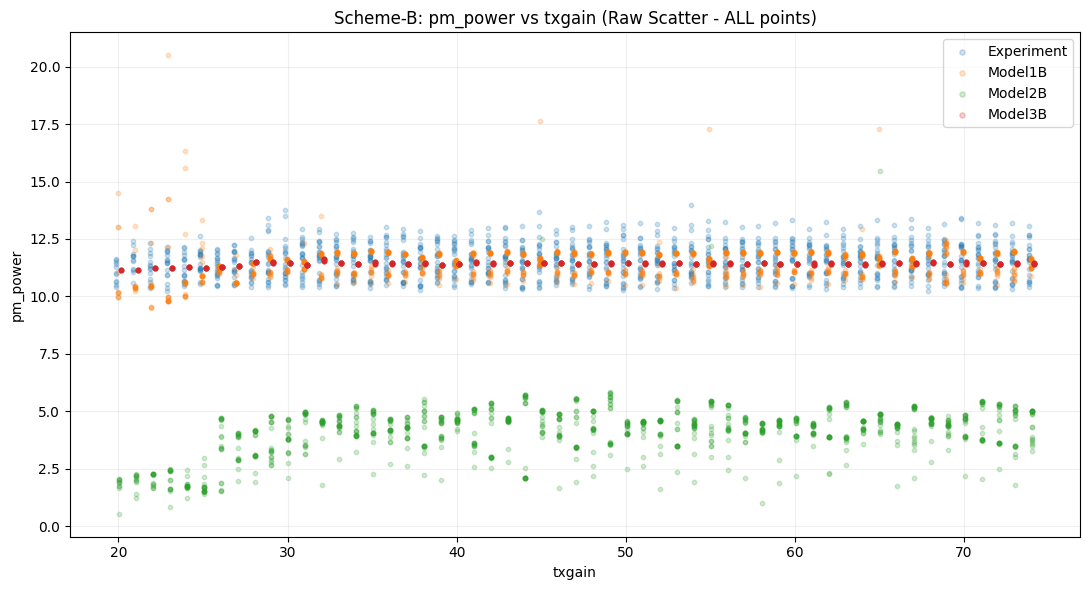

Scheme-B: pm_power vs txgain (Raw Scatter - ALL points)
Total points plotted (raw): 1158
[Model1B] MSE=0.6831 RMSE=0.8265 MAE=0.5125 MRE=4.42%
[Model2B] MSE=56.4760 RMSE=7.5151 MAE=7.4488 MRE=64.53%
[Model3B] MSE=0.5330 RMSE=0.7301 MAE=0.6069 MRE=5.21%


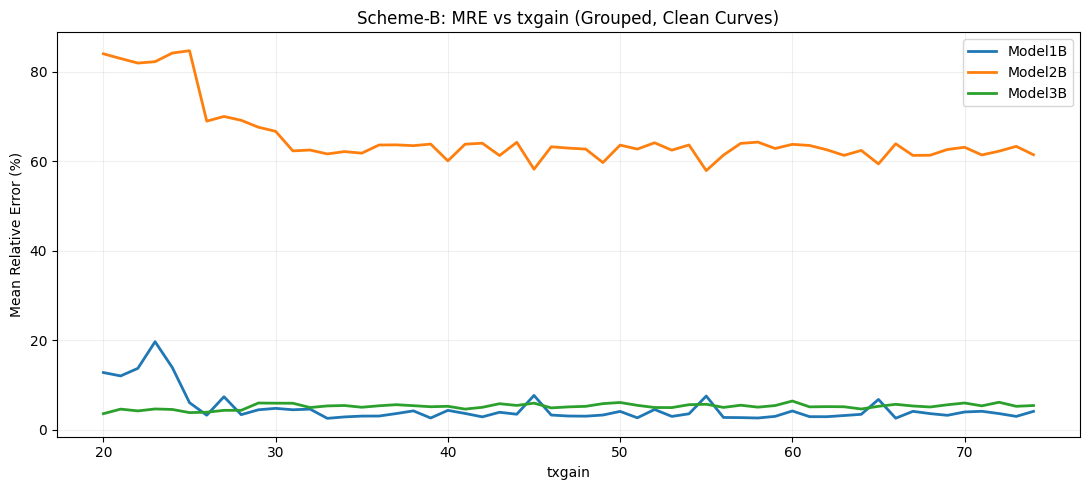

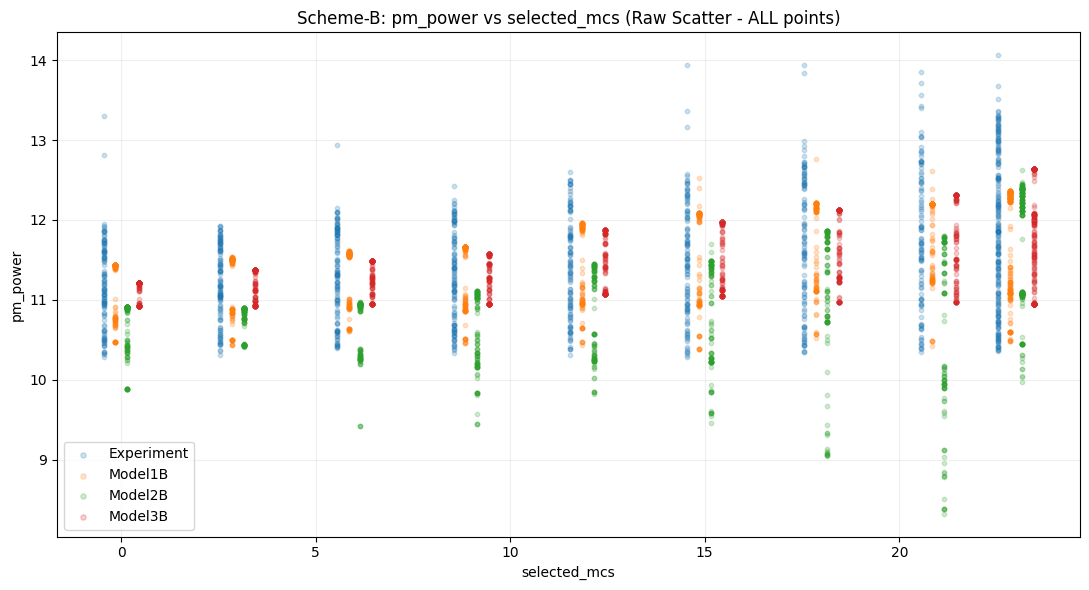

Scheme-B: pm_power vs selected_mcs (Raw Scatter - ALL points)
Total points plotted (raw): 1156
[Model1B] MSE=0.2243 RMSE=0.4736 MAE=0.3611 MRE=3.10%
[Model2B] MSE=0.7317 RMSE=0.8554 MAE=0.6747 MRE=5.77%
[Model3B] MSE=0.1683 RMSE=0.4102 MAE=0.3263 MRE=2.82%


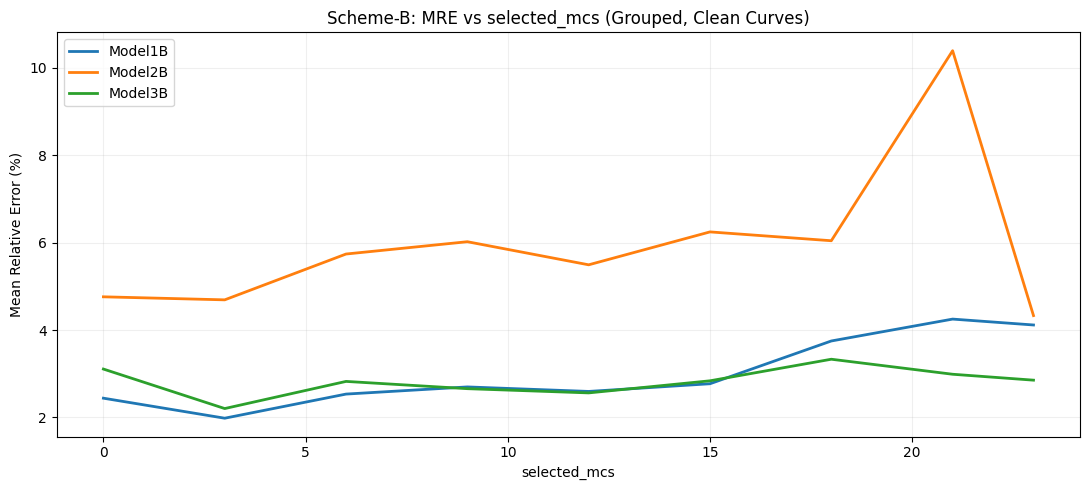

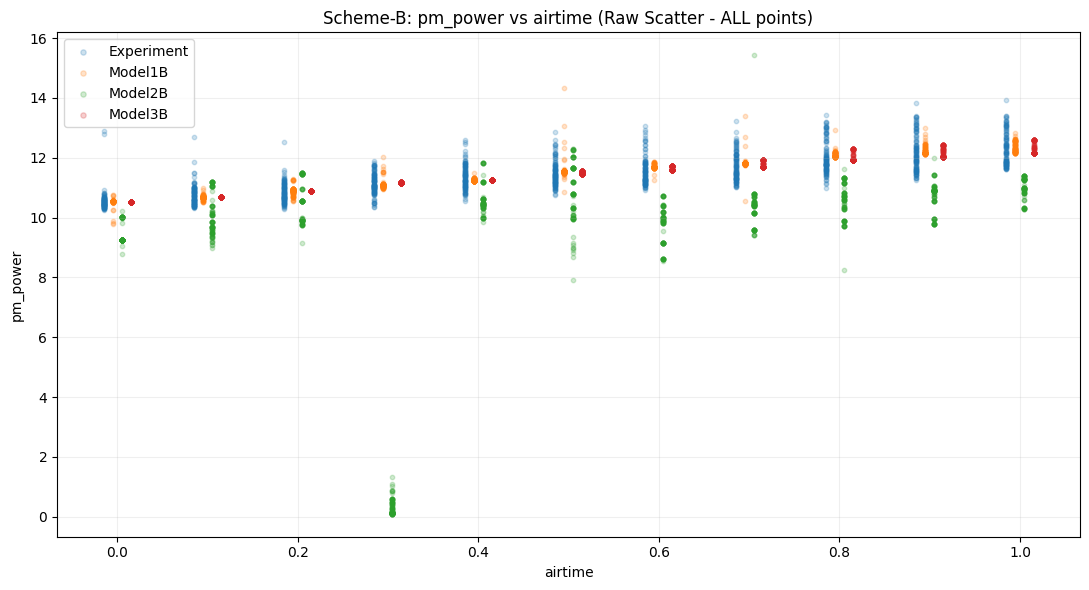

Scheme-B: pm_power vs airtime (Raw Scatter - ALL points)
Total points plotted (raw): 1159
[Model1B] MSE=0.2040 RMSE=0.4516 MAE=0.3429 MRE=2.95%
[Model2B] MSE=12.8003 RMSE=3.5777 MAE=2.1049 MRE=18.46%
[Model3B] MSE=0.1545 RMSE=0.3931 MAE=0.2975 MRE=2.56%


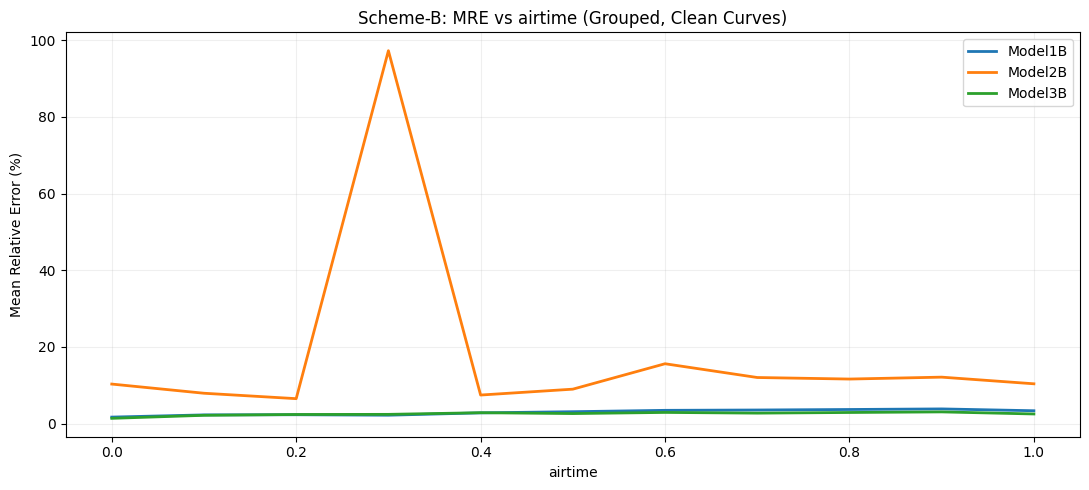

In [23]:
# ============================================================
# SCATTER (ALL POINTS) + CLEAN MRE CURVES — Scheme B
# Compare Model1B vs Model2B vs Model3B
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


# ------------------------------------------------------------
# 0) Metrics
# ------------------------------------------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mre = mean_relative_error(y_true, y_pred)
    return mse, rmse, mae, mre


# ------------------------------------------------------------
# 1) Helper: robustly fetch prediction key (兼容不同命名)
# ------------------------------------------------------------
def _pick_pred_key(d, candidates):
    for k in candidates:
        if k in d:
            return k
    raise KeyError(f"Cannot find prediction key in dict. Tried: {candidates}. Keys={list(d.keys())}")

def _as_float(x):
    try:
        return float(x)
    except Exception:
        # 有些 slice_value 可能是 numpy 类型 / 字符串
        return float(np.asarray(x).item())


# ------------------------------------------------------------
# 2) Build unified raw DF for scheme B (concatenate all slices)
# ------------------------------------------------------------
def build_raw_test_dataframe_B(exp_name, xcol, test_outputs_m1B, test_outputs_m2B, test_outputs_m3B):
    """
    Scheme B: each slice_value has its own trained model + its own test set.
    We concatenate ALL slice test points into one big df_plot for scatter/MRE curves.
    """

    # 兼容：有的人用 test_outputs_m1B[exp_name]，有的人用 test_outputs_m1B["m1"][exp_name]
    # 这里默认就是 test_outputs_m1B[exp_name]
    d_m1 = test_outputs_m1B[exp_name]
    d_m2 = test_outputs_m2B[exp_name]
    d_m3 = test_outputs_m3B[exp_name]

    def norm_map(d):
        mp = {}
        for k, v in d.items():
            mp[_as_float(k)] = v
        return mp

    m1 = norm_map(d_m1)
    m2 = norm_map(d_m2)
    m3 = norm_map(d_m3)

    common_keys = sorted(set(m1.keys()) & set(m2.keys()) & set(m3.keys()))
    if len(common_keys) == 0:
        raise ValueError(f"No common slice keys for exp={exp_name}. "
                         f"m1={len(m1)}, m2={len(m2)}, m3={len(m3)}")

    rows = []

    # slice_value 可能是 float，也可能是字符串
    for s in common_keys:

        d1 = m1[s]
        d2 = m2[s]
        d3 = m3[s]

        # 兼容预测字段命名
        k1 = _pick_pred_key(d1, ["y_pred_m1B", "y_pred_m1", "y_pred"])
        k2 = _pick_pred_key(d2, ["y_pred_m2B", "y_pred_m2", "y_pred"])
        k3 = _pick_pred_key(d3, ["y_pred_m3B", "y_pred_m3", "y_pred"])

        y_true = np.asarray(d1["y_true"]).reshape(-1)
        y_m1   = np.asarray(d1[k1]).reshape(-1)
        y_m2   = np.asarray(d2[k2]).reshape(-1)
        y_m3   = np.asarray(d3[k3]).reshape(-1)

        # 方案B：同一个 slice 内 x 恒等于 sval
        n = min(len(y_true), len(y_m1), len(y_m2), len(y_m3))
        if n == 0:
            continue
        
        y_true, y_m1, y_m2, y_m3 = y_true[:n], y_m1[:n], y_m2[:n], y_m3[:n]
        x = np.full(n, s, dtype=float)

        rows.append(pd.DataFrame({
            xcol: x,
            "y_true": y_true,
            "y_pred_m1": y_m1,
            "y_pred_m2": y_m2,
            "y_pred_m3": y_m3,
            "slice_value": s
        }))

    if len(rows) == 0:
        raise ValueError(f"Rows empty for exp={exp_name}. Possibly all slices had n==0 after alignment.")

    df_plot = pd.concat(rows, ignore_index=True)

    df_plot = df_plot.dropna(subset=[xcol, "y_true"]).copy()
    return df_plot


# ------------------------------------------------------------
# 3) Full raw scatter (ALL points) with horizontal offsets
# ------------------------------------------------------------
def plot_raw_scatter_with_offset_full(
    df_plot,
    xcol,
    title,
    offset_fraction=0.03,
    point_size=10,
    alpha=0.25,
    figsize=(11, 6)
):
    d = df_plot.dropna().copy()
    d = d.sort_values(xcol)

    x = d[xcol].to_numpy()
    x_unique = np.unique(x)
    unique_ratio = len(x_unique) / max(len(x), 1)

    # scheme B is usually discrete slices, but keep auto logic
    if len(x_unique) <= 60 or unique_ratio < 0.02:
        if len(x_unique) > 1:
            steps = np.diff(np.sort(x_unique))
            steps = steps[steps > 0]
            step = float(np.median(steps)) if len(steps) else 1.0
        else:
            step = 1.0
        dx = 0.1 * step
    else:
        x_min, x_max = float(np.min(x)), float(np.max(x))
        x_range = max(x_max - x_min, 1e-9)
        dx = offset_fraction * x_range

    offsets = {"exp": -1.5 * dx, "m1": -0.5 * dx, "m2": 0.5 * dx, "m3": 1.5 * dx}

    # metrics
    m1 = compute_metrics(d["y_true"], d["y_pred_m1"])
    m2 = compute_metrics(d["y_true"], d["y_pred_m2"])
    m3 = compute_metrics(d["y_true"], d["y_pred_m3"])

    plt.figure(figsize=figsize)
    plt.scatter(x + offsets["exp"], d["y_true"],    s=point_size, alpha=alpha, label="Experiment")
    plt.scatter(x + offsets["m1"],  d["y_pred_m1"], s=point_size, alpha=alpha, label="Model1B")
    plt.scatter(x + offsets["m2"],  d["y_pred_m2"], s=point_size, alpha=alpha, label="Model2B")
    plt.scatter(x + offsets["m3"],  d["y_pred_m3"], s=point_size, alpha=alpha, label="Model3B")

    plt.xlabel(xcol)
    plt.ylabel("pm_power")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend(markerscale=1.2, frameon=True)
    plt.tight_layout()
    plt.show()

    print("=" * 60)
    print(title)
    print(f"Total points plotted (raw): {len(d)}")
    print(f"[Model1B] MSE={m1[0]:.4f} RMSE={m1[1]:.4f} MAE={m1[2]:.4f} MRE={m1[3]:.2f}%")
    print(f"[Model2B] MSE={m2[0]:.4f} RMSE={m2[1]:.4f} MAE={m2[2]:.4f} MRE={m2[3]:.2f}%")
    print(f"[Model3B] MSE={m3[0]:.4f} RMSE={m3[1]:.4f} MAE={m3[2]:.4f} MRE={m3[3]:.2f}%")
    print("=" * 60)


# ------------------------------------------------------------
# 4) Clean MRE curves (grouped by x)
# ------------------------------------------------------------
def group_mean_mre_curve(df_plot, xcol, pred_col, eps=1e-9, min_count=1):
    d = df_plot[[xcol, "y_true", pred_col]].dropna().copy()
    d["rel_err"] = (np.abs(d["y_true"] - d[pred_col]) / (np.abs(d["y_true"]) + eps)) * 100

    g = d.groupby(xcol).agg(
        mre=("rel_err", "mean"),
        n=("rel_err", "size")
    ).reset_index()

    g = g[g["n"] >= min_count].copy()
    g = g.sort_values(xcol)
    return g

def plot_mre_curves_clean(df_plot, xcol, title, min_count=1, figsize=(11, 5)):
    g1 = group_mean_mre_curve(df_plot, xcol, "y_pred_m1", min_count=min_count)
    g2 = group_mean_mre_curve(df_plot, xcol, "y_pred_m2", min_count=min_count)
    g3 = group_mean_mre_curve(df_plot, xcol, "y_pred_m3", min_count=min_count)

    plt.figure(figsize=figsize)
    plt.plot(g1[xcol], g1["mre"], label="Model1B", linewidth=2)
    plt.plot(g2[xcol], g2["mre"], label="Model2B", linewidth=2)
    plt.plot(g3[xcol], g3["mre"], label="Model3B", linewidth=2)

    plt.xlabel(xcol)
    plt.ylabel("Mean Relative Error (%)")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 5) Run plots for gain / mcs / airtime (scheme B)
# ------------------------------------------------------------
# You MUST already have:
#   test_outputs_m1B, test_outputs_m2B, test_outputs_m3B
# in memory.

PLOT_CONFIG = {
    "gain":    ("txgain",        "Scheme-B: pm_power vs txgain (Raw Scatter - ALL points)"),
    "mcs":     ("selected_mcs",  "Scheme-B: pm_power vs selected_mcs (Raw Scatter - ALL points)"),
    "airtime": ("airtime",       "Scheme-B: pm_power vs airtime (Raw Scatter - ALL points)"),
}

import inspect
print(inspect.signature(build_raw_test_dataframe_B))


for exp_name, (xcol, title) in PLOT_CONFIG.items():
    df_plot = build_raw_test_dataframe_B(
        exp_name=exp_name,
        xcol=xcol,
        test_outputs_m1B=test_outputs_m1_slices,
        test_outputs_m2B=test_outputs_m2_slices,
        test_outputs_m3B=test_outputs_m3B
    )

    plot_raw_scatter_with_offset_full(
        df_plot=df_plot,
        xcol=xcol,
        title=title,
        offset_fraction=0.02,
        point_size=10,
        alpha=0.22,
        figsize=(11, 6)
    )

    plot_mre_curves_clean(
        df_plot=df_plot,
        xcol=xcol,
        title=f"Scheme-B: MRE vs {xcol} (Grouped, Clean Curves)",
        min_count=1
    )
